In [55]:
from multiclass_function_2 import *
import torch
from torchvision import datasets, transforms
import copy

In [57]:
BATCH_SIZE = 64
LR = 2e-3
LR_STEP = 3 # for LR STEP
LR_GAMMA = 0.9 # for LR STEP
EPOCH = 30
TRAIN_RATIO = 0.8
criterion = nn.CrossEntropyLoss()
new_model_train = True
model_type = "CNN_deep"
dataset = "STL10"
save_model_path = f"./result/{model_type}_{dataset}.pt"
save_history_path = f"./result/{model_type}_history_{dataset}.pt"

In [ ]:
def to_uint8(x):
    return (255*x).type(torch.uint8)

In [38]:
'''
<Overfitting 방지 - Data augmentation>
overfitting은 꼭 모델이 복잡해서가 아니고 데이터의 수가 적어도 발생 할 수 있다.

Data 적으면 어케..?
1. data 모아라... 노가다..
2. data augmentation 하자 -> 기존 데이터 우려먹기..
'''

transform_train = transforms.Compose([
    transforms.ToTensor(),

    # transforms.Lambda(to_uint8),
    # to_uint8, # 가능
    # transforms.Lambda(lambda x:(255*x).type(torch.uint8)),
    # lambda x:(255*x).type(torch.uint8), # 가능
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    # (아마도) 이미지넷 데이터 전체 픽셀에 대해서 구한 평균, std 값

    #transforms.Resize(size=(20,20)), # size는 (height,width)
    # transforms.CenterCrop(size=(20,20)), # size 는 (height, width)
    #transforms.Pad(6), # 20+6*2 = 32

    # transforms.RandomApply(nn.ModuleList([transforms.CenterCrop(size=(20,20)),
    #                                        transforms.Pad(6)]), p=0.5), # ModuleList 안해도 되더라

    # transforms.RandomCrop(size=(20,20)), # 어디를 자를지 random 하게 자름
    # transforms.RandomResizedCrop(size=(20,20), scale=(0.3,1), ratio=(0.3,1.7)),
    # random 하게 자른 다음에 resize라서 RandomCrop과 다름
    # scale은 어느 정도로 작은 범위를 자를지 (0~1 사이 값)
    # ratio는 aspect ratio로, 가로 길이/세로 길이 를 의미한다.
    # (a,b) <- a 와 b 사이 값을 uniform random 하게 뽑아요

    # transforms.RandomGrayscale(p=0.5), # gray로 바꾸는 데, 출력 채널 수를 3으로 유지
    # transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.5, hue=0.15),
    # 밝기, 대비, 채도, 색조가 센서마다 다를 수 있음을 고려 (number: percentage to convert)
    # 밝기(brightness)를 키우면 밝은 부분에서 saturation이 일어나면서, HDR이 낮은 센서에 대응 가능
    # 대비(contrast) augmentation은 HDR이 서로 다른 센서에 대응 가능
    # 채도(saturation) 및 색조(hue) augmentation은 ISP에서 color correction matrix 값이 센서마다 서로 다른 경우 등,
    # 색 표현이 다른 센서에 대응 가능
    # transforms.RandomAutocontrast(p=0.5), # p의 확률로 대비를 자동 조정
    # transforms.RandomEqualize(p=0.5), # p의 확률로 R,G,B histogram을 일치시킴 (이건 uint8로 되어있는 이미지만 가능)
    # transforms.RandomInvert(p=0.5), # p의 확률로 색반전
    # new 픽셀 값 = 최댓 값 - 기존의 픽셀 값 을 통해 반전시킴
    # transforms.RandomSolarize(threshold=200, p=0.5),
    # p의 확률로(즉 그 이미지에 대해 할지 말지 정하고) threshold 넘는 픽셀 값에 대해 inverting
    # transforms.RandomPosterize(bits=3, p=0.5),
    # 픽셀 하나가 가지는 값의 bit수(0~8)를 p의 확률로 bits로 바꿈 (이건 uint8로 되어있는 것만 가능)

    # transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1,2)),
    # kernel_size = (가로,세로) sigma=(min,max) min ~ max 에서 uniform 하게 하나 뽑음
    # transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    # sharpness_factor = 1 이면 원래 이미지, 0에 가까우면 blur, 1보다 클수록 sharp해짐

    # transforms.RandomHorizontalFlip(p=0.4), # p 확률로 좌우반전
    # transforms.RandomVerticalFlip(p=0.5), # p 확률로 상하반전
    # transforms.RandomRotation(degrees=(0,180)), # 0~180도 랜덤하게 회전
    # transforms.RandomAffine(degrees=(0,30),translate=(0.1,0.3),scale=(0.5,1.2)),
    # translate는 이동하는 정도 (비율), scale은 크기 조절
    # transforms.RandomPerspective(distortion_scale=0.6, p=0.5), # distortion 정도 0~1 사이, default는 0.5, p는 적용 확률

    # transforms.RandomErasing(p=0.5, scale=(0.03,0.3), ratio=(0.3,3.3)),
    # scale: 이미지의 몇 퍼 정도를 지울지
    # ratio: 지우는 영역의 aspect ratio

    # transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    # transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN),
    # AutoAugment:Learning Augmentation Strategies from Data 라는 논문에 따른 augmentation (uint8 이여야 함)
    # transforms.RandAugment(),
    # RandAugment: Practical automated data augmentation with a reduced search space 라는 논문에 따른 augmentation (uint8 이여야 함)
    # transforms.TrivialAugmentWide(),
    # TrivialAugment: Tuning-free Yet State-of-the-Art Data Augmentation 라는 논문에 따른 augmentation (uint8)
    # transforms.AugMix(),
    # AugMix: A Simple Data Processing Method to Improve Robustness and Uncertainty 라는 논문에 따른 augmentaiton (uint8)
    ])
transform_test = transforms.ToTensor()

In [39]:
# train_DS = datasets.CIFAR10(root = '/Users/sanghyun/Desktop/GIT_Folder', train = True, download=False, transform=transform_train)
# test_DS = datasets.CIFAR10(root  = '/Users/sanghyun/Desktop/GIT_Folder', train = False, download=False, transform=transform_test)

train_DS = datasets.STL10(root = '/Users/sanghyun/Desktop/GIT_Folder', split='train', download=False, transform=transform_train)
test_DS = datasets.STL10(root  = '/Users/sanghyun/Desktop/GIT_Folder', split='test', download=False, transform=transform_test)

NoT = int(len(train_DS)*TRAIN_RATIO)
NoV = len(train_DS) - NoT

train_DS, val_DS= torch.utils.data.random_split(train_DS, [NoT, NoV])

val_DS.transform = transform_test # test의 transform 적용!

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=False) # 이미지 변형 체크 할땐 False로
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=False) # 이미지 변형 체크 할땐 False로

원본
x_batch size = torch.Size([64, 3, 32, 32])
변환
x_batch size = torch.Size([64, 3, 20, 20])


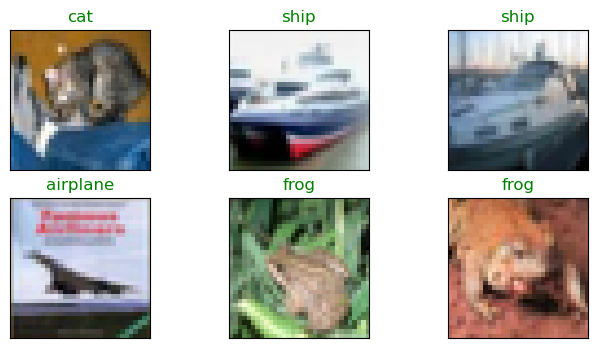

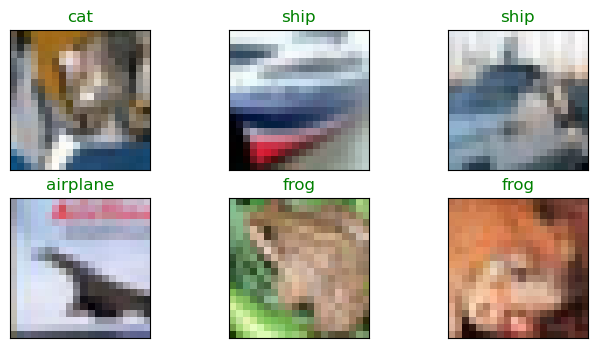

In [35]:
test_DS_wT = copy.deepcopy(test_DS) # wT = with Transform
test_DS_wT.transform = transform_train # 데이터 변경한거
test_DL_wT = torch.utils.data.DataLoader(test_DS_wT, batch_size = BATCH_SIZE, shuffle = False)

print("원본")
im_plot(test_DL)
print("변환")
im_plot(test_DL_wT)

In [4]:
print(train_DS)
print(test_DS)
print(len(train_DS))
print(len(test_DS))
print(test_DS.classes)

Dataset STL10
    Number of datapoints: 5000
    Root location: /Users/sanghyun/Desktop/GIT_Folder
    Split: train
    StandardTransform
Transform: ToTensor()
Dataset STL10
    Number of datapoints: 8000
    Root location: /Users/sanghyun/Desktop/GIT_Folder
    Split: test
    StandardTransform
Transform: ToTensor()
5000
8000
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [ ]:
x_batch, y_batch = next(iter(test_DL))

In [32]:
print(x_batch.shape)
print(x_batch.dtype)

torch.Size([32, 3, 96, 96])
torch.float32


In [30]:
x_batch = x_batch.to(DEVICE)
y_batch = y_batch.to(DEVICE)

In [ ]:
plt.imshow(x_batch[7].permute(1, 2, 0))

In [58]:
class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(nn.Conv2d(64,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)

        self.classifier = nn.Sequential(nn.Linear(128*12*12,512),
                                        nn.Linear(512,10))

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [50]:
# for test
model = CNN_deep().to(DEVICE)
#print(model(x_batch).shape)

In [59]:
exec(f"model = {model_type}().to(DEVICE)")
print(model)

CNN_deep(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=

In [ ]:
if new_model_train:
    optimizer = optim.Adam(model.parameters(), lr=LR)
    # loss_history = Train(model, train_DL, criterion, optimizer, EPOCH, )
    loss_history = Train(model, train_DL, val_DL, criterion, optimizer, EPOCH,
          BATCH_SIZE, TRAIN_RATIO,
          save_model_path, save_history_path)

    torch.save(model, save_model_path)

In [61]:
load_model = torch.load(save_model_path, map_location=DEVICE, weights_only=False)

In [64]:
Test(load_model, test_DL, criterion)


Test loss: 2.48745
Test accuracy: 3978/8000 (49.7 %)


49.7

9915626


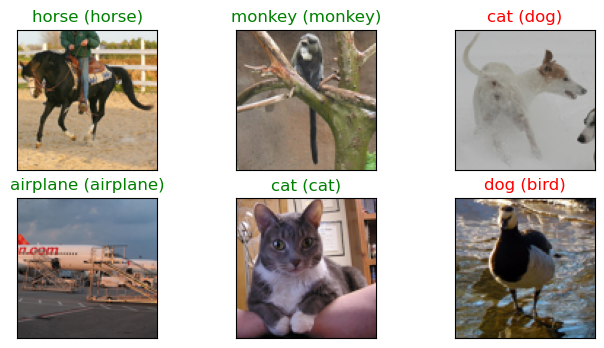

In [65]:
Test_plot(load_model, test_DL)
print(count_params(load_model))